In [11]:
#0 - Short Data
#1 - Julian
#2 - Count
#3 - T
#4 - Tmax
#5 - Tmin
#6 - U2
#7 - es (Tmin)
#8 - es(Tmin)
#9 - es
#10 - ea
#11 - Δ
#12 - P
#13 - RS
#14 - RH
#15 - RH_max
#16 - RH_min
#17 - Soil Temp
#18 - Rn
#19 - Ra
#20 - dt
#21 - es-ea
#22 - Eτο

## Optimisation instructions

1. Define unknows as xm1, xm2 ...
2. Define known as ym
3. Define in calc_y the extra parameters
4. Give an initial guess for the extra parameter

In [55]:
import numpy as np
import sklearn
from sklearn import model_selection
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set_style("whitegrid")

bootstrap = 1000
params = []
evalu = []

# data file
df = pd.read_excel('auth.xlsx', skiprows=[1, 2], index_col = 0)
X_multi = df.drop('Ετο', 1)
Y_target = df.Ετο

for i in range(bootstrap):
    # Grab the output and set as X and Y test and train data sets!
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df, Y_target, test_size = 0.3, shuffle = True)

    xm1 = np.array(X_train["RS"])
    xm2 = np.array(X_train["es-ea"])
    xm3 = np.array(X_train["Julian"])
    ym = np.array(Y_train)

    # calculate y
    def calc_y(x):
        a = x[0]
        b = x[1]
        c = x[2]
    #     d = x[3]
        #y = a * xm1 + b                                             # linear regression
        y = a * xm1 ** 2 + b * np.sqrt(xm2) ** 2 + c                 # nonlinear regression
        return y

    def objective(x):
        y = calc_y(x)
        obj = 0.0
        for i in range(len(ym)):
            obj = obj + ((y[i]-ym[i])/ym[i])**2    
        return obj

    # initial guesses
    x0 = np.zeros(3) #Number of parameters
    x0[0] = 0.0 # a
    x0[1] = 0.0 # b
    x0[2] = 0.0 # c
    # x0[3] = 0.0 # d

    # optimize
    solution = minimize(objective, x0, method='SLSQP')
    x = solution.x
    y = calc_y(x)

    #Validation
    y_pred = x[0] * X_test["RS"] ** 2 + x[1] * np.sqrt(X_test["es-ea"]) ** 2 + x[2]

    slope, intercept, r_value, p_value, std_err = stats.linregress(Y_train, y)
    r2 = r_value**2

    slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(Y_test, y_pred)
    r2_test = r_value_test**2
    
    params.append(x)
    evalu.append(r2_test)

params_m = pd.DataFrame(params).mean(axis = 0)
evalu_m = pd.DataFrame(evalu).mean()

print('R^2', np.round((evalu_m), 3))

R^2 0    0.920756
dtype: float64


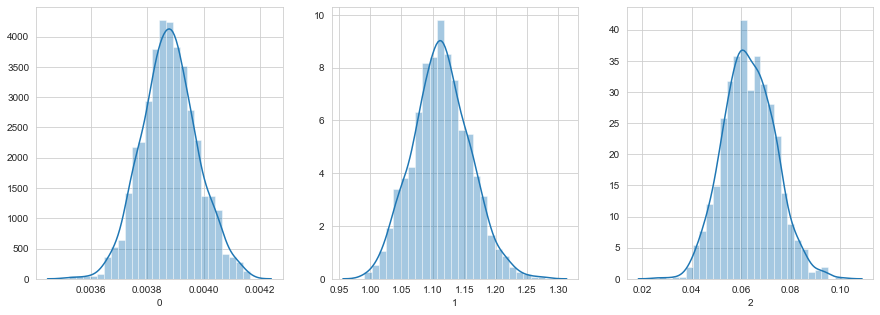

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
sns.distplot(pd.DataFrame(params).iloc[:, 0], ax = ax1);
sns.distplot(pd.DataFrame(params).iloc[:, 1], ax = ax2);
sns.distplot(pd.DataFrame(params).iloc[:, 2], ax = ax3);